**Part 0**: Setup

Imports:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import random

File setup

In [ ]:
!gdown 1MWRLEKTJ4fRzfq-2uZYZUYDhqUocu9ew

Downloading...
From (original): https://drive.google.com/uc?id=1MWRLEKTJ4fRzfq-2uZYZUYDhqUocu9ew
From (redirected): https://drive.google.com/uc?id=1MWRLEKTJ4fRzfq-2uZYZUYDhqUocu9ew&confirm=t&uuid=a096e1bb-ab54-4fc7-a65e-efe76ccafc93
To: /content/data.csv
100% 162M/162M [00:03<00:00, 53.3MB/s]


In [ ]:
df_raw = pd.read_csv("/content/data.csv")

df_raw.drop("Unnamed: 0", inplace=True, axis=1)

Data cleanup and adding extra features

In [ ]:
numerical = ['COLLISION_TIME', 'COLLISION_DATE', 'MONTH', 'DAY', 'YEAR', 'HOUR', 'HOUR2', 'MINUTE', 'DAY_OF_WEEK']
categorical = ['WEATHER_1', 'WEATHER_2', 'LOCATION_TYPE','RAMP_INTERSECTION']
features = numerical + categorical

In [ ]:
df_raw.fillna({"ALCOHOL_INVOLVED": "N"}, inplace=True)
df_raw.drop("PEDESTRIAN_ACCIDENT", inplace=True, axis=1)
df_raw.dropna(inplace=True)

# remapping of time to consider time between 0 (midnight) and 6 as hours 24-30
def timemap(h):
    if h >= 0 and h < 6:
        return 24 + h
    return h

# numerical
tmp = df_raw["COLLISION_DATE"] % 10000
df_raw["MONTH"] = tmp // 100
df_raw["DAY"] = tmp % 100
df_raw["YEAR"] = df_raw["COLLISION_DATE"] // 10000
df_raw["HOUR"] = df_raw["COLLISION_TIME"] // 100
df_raw["HOUR2"] = df_raw["HOUR"].map(timemap)

df_raw["MINUTE"] = df_raw["COLLISION_TIME"] % 100

# numerical version of alcohol involvement
df_raw["ALC"] = df_raw["ALCOHOL_INVOLVED"].map(lambda x: 1 if x == "Y" else 0)

df_raw.head()

,ALCOHOL_INVOLVED,COLLISION_TIME,COLLISION_DATE,DAY_OF_WEEK,WEATHER_1,WEATHER_2,LOCATION_TYPE,RAMP_INTERSECTION,MONTH,DAY,YEAR,HOUR,HOUR2,MINUTE,ALC
3,N,145,20090228,6,A,-,H,-,2,28,2009,1,25,45,0
4,N,1020,20090209,1,C,-,H,-,2,9,2009,10,10,20,0
5,N,1550,20090218,3,A,-,H,-,2,18,2009,15,15,50,0
6,N,1735,20090211,3,B,-,H,-,2,11,2009,17,17,35,0
7,N,2120,20090213,5,A,-,H,-,2,13,2009,21,21,20,0


In [ ]:
random.seed(100) # setting random seed

Sampling from database (for performance and to balance classes)

In [ ]:
n = 1000

yalc = df_raw[df_raw["ALC"] == 1]
nalc = df_raw[df_raw["ALC"] == 0]

sample_yalc = yalc.iloc[random.sample(range(yalc.shape[0]), n)]
sample_nalc = nalc.iloc[random.sample(range(nalc.shape[0]), 2 * n)]

In [ ]:
df = pd.concat([sample_yalc, sample_nalc])

df

,ALCOHOL_INVOLVED,COLLISION_TIME,COLLISION_DATE,DAY_OF_WEEK,WEATHER_1,WEATHER_2,LOCATION_TYPE,RAMP_INTERSECTION,MONTH,DAY,YEAR,HOUR,HOUR2,MINUTE,ALC
630731,Y,315,20100724,6,A,-,H,-,7,24,2010,3,27,15,1
1998736,Y,520,20140103,5,A,-,H,-,1,3,2014,5,29,20,1
1978909,Y,158,20131213,5,A,-,H,-,12,13,2013,1,25,58,1
759441,Y,2140,20101112,5,A,-,H,-,11,12,2010,21,21,40,1
1704344,Y,1510,20130318,1,A,-,H,-,3,18,2013,15,15,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1806085,N,830,20130520,1,A,-,H,-,5,20,2013,8,8,30,0
643487,N,1230,20100605,6,A,-,H,-,6,5,2010,12,12,30,0
605138,N,1935,20100614,1,A,-,H,-,6,14,2010,19,19,35,0
2389909,N,2215,20150126,1,A,-,H,-,1,26,2015,22,22,15,0


In [ ]:
def report(y_true, y_pred):
    print(f"Accuracy score: {accuracy_score(y_true, y_pred)}")
    print(f"Precision: {precision_score(y_true, y_pred)}")
    print(f"Recall: {recall_score(y_true, y_pred)}")
    print(f"F1: {f1_score(y_true, y_pred)}")
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))

**Part 0.5**: EDA

Correlation matrix between numerical features and alcohol involvement

In [ ]:
df[numerical].corrwith(df["ALC"])

,0
COLLISION_TIME,-0.093967
COLLISION_DATE,0.009353
MONTH,0.011931
DAY,0.005163
YEAR,0.009188
HOUR,-0.093907
HOUR2,0.475800
MINUTE,0.002109
DAY_OF_WEEK,0.200904


Visualization of the distribution of collisions over the hours of the day

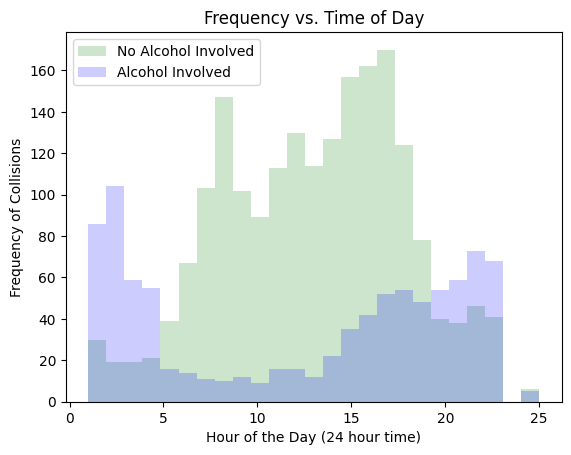

In [ ]:
fig = plt.figure()

plt.hist(x=sample_nalc["HOUR"],bins=25, color="green", alpha=0.2, range=(1, 25), label="No Alcohol Involved")
plt.hist(x=sample_yalc["HOUR"],bins=25, color="blue", alpha=0.2, range=(1, 25), label="Alcohol Involved")

plt.xlabel("Hour of the Day (24 hour time)")
plt.ylabel("Frequency of Collisions")
plt.title("Frequency vs. Time of Day")

plt.legend()

fig.show()

Visualization of the distribution of collisions over the hours of the day, with hours 12 AM (0:00) - 6 AM mapped to hours 24:00 - 30:00

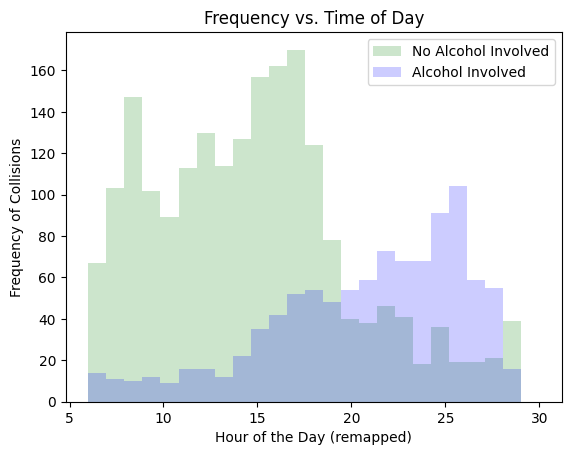

In [ ]:
fig = plt.figure()

plt.hist(x=sample_nalc["HOUR2"],bins=25, color="green", alpha=0.2, range=(6, 30), label="No Alcohol Involved")
plt.hist(x=sample_yalc["HOUR2"],bins=25, color="blue", alpha=0.2, range=(6, 30), label="Alcohol Involved")

plt.xlabel("Hour of the Day (remapped)")
plt.ylabel("Frequency of Collisions")
plt.title("Frequency vs. Time of Day")

plt.legend()

fig.show()

Visualization of the distribution of collisions over the days of the year \
Note: the dates are converted to decimals representing the progress through each month (e.g. 12/15 would be approximately 12.5). This is done to create a continuous distribution

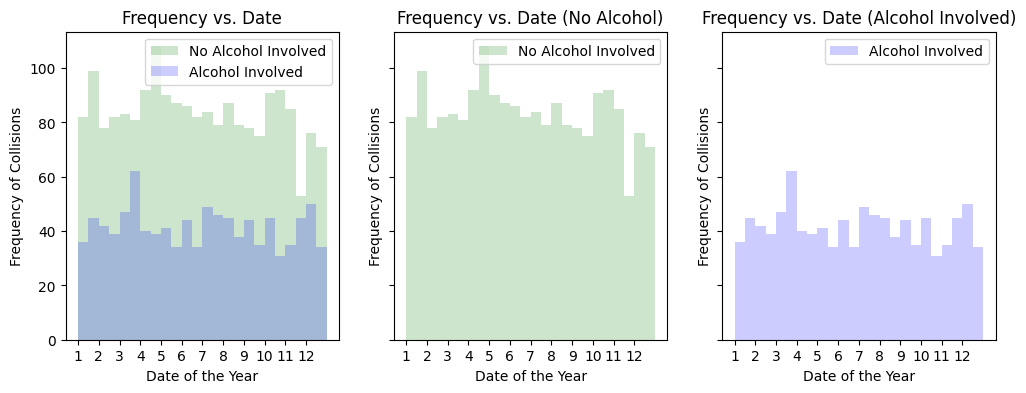

In [ ]:
def datemap(date):
    month_lens = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31] # days in each month
    d = date % 10000 # convert to mmdd
    month = d // 100
    day = d % 100
    return (month * 100) + (day / month_lens[month - 1]) * 100

fig, axes = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(12, 4))

axes[0].hist(x=sample_nalc["COLLISION_DATE"].map(datemap), bins=24, color="green", alpha=0.2, range=(100, 1300), label="No Alcohol Involved")
axes[0].hist(x=sample_yalc["COLLISION_DATE"].map(datemap), bins=24, color="blue", alpha=0.2, range=(100, 1300), label="Alcohol Involved")

axes[0].set_xlabel("Date of the Year")
axes[0].set_ylabel("Frequency of Collisions")
axes[0].set_title("Frequency vs. Date")

axes[0].set_xticks(range(100, 1300, 100), labels=[str(i) for i in range(1, 13)])
axes[0].legend()

axes[1].hist(x=sample_nalc["COLLISION_DATE"].map(datemap), bins=24, color="green", alpha=0.2, range=(100, 1300), label="No Alcohol Involved")

axes[1].set_xlabel("Date of the Year")
axes[1].set_ylabel("Frequency of Collisions")
axes[1].set_title("Frequency vs. Date (No Alcohol)")

axes[1].legend()

axes[2].hist(x=sample_yalc["COLLISION_DATE"].map(datemap), bins=24, color="blue", alpha=0.2, range=(100, 1300), label="Alcohol Involved")

axes[2].set_xlabel("Date of the Year")
axes[2].set_ylabel("Frequency of Collisions")
axes[2].set_title("Frequency vs. Date (Alcohol Involved)")

axes[2].legend()

fig.show()

Visualization of the distribution of collisions over the days of the week

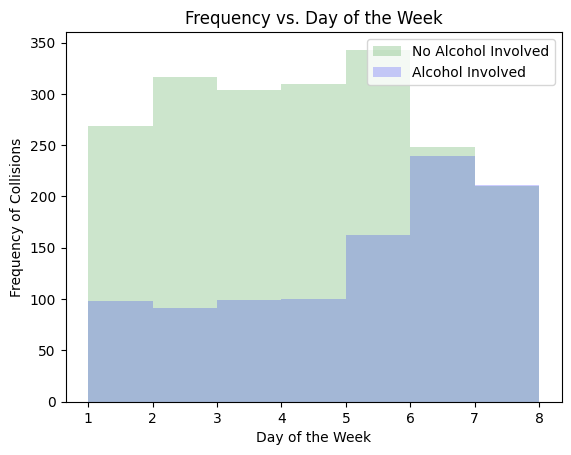

In [ ]:
fig = plt.figure()

plt.hist(x=sample_nalc["DAY_OF_WEEK"],bins=7, color="green", alpha=0.2, range=(1, 8), label="No Alcohol Involved")
plt.hist(x=sample_yalc["DAY_OF_WEEK"],bins=7, color="blue", alpha=0.2, range=(1, 8), label="Alcohol Involved")

plt.xlabel("Day of the Week")
plt.ylabel("Frequency of Collisions")
plt.title("Frequency vs. Day of the Week")

plt.legend()

fig.show()

Crosstab between alcohol involvement and categorical features

In [ ]:
def crosstab(category):
    print(pd.crosstab(df["ALCOHOL_INVOLVED"], df[category]))
    print("-" * 60)

for category in categorical:
    crosstab(category)

WEATHER_1         -     A    B   C  D  E  F  G
ALCOHOL_INVOLVED                              
N                 3  1621  276  82  8  5  3  2
Y                 1   823  120  43  4  7  2  0
------------------------------------------------------------
WEATHER_2            -  B   C  D  E  F  G
ALCOHOL_INVOLVED                         
N                 1930  2  61  1  1  3  2
Y                  969  4  19  2  1  1  4
------------------------------------------------------------
LOCATION_TYPE        H    I    R
ALCOHOL_INVOLVED                
N                 1536  138  326
Y                  726   99  175
------------------------------------------------------------
RAMP_INTERSECTION     -   1   2   3    4    5   6
ALCOHOL_INVOLVED                                 
N                  1536  97  95  14  120  105  33
Y                   726  36  63  17   59   69  30
------------------------------------------------------------


Comment: out of the categorical variables, it seems that all of them have a weak (but noticable) relation to whether or not alcohol was involved, except for WEATHER_1.

**Part 1**: Classifiers using all features in `features` list

K Neighbors Classifier:

In [ ]:
ct = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), categorical),
    remainder = "passthrough",
)

pipeline_knn = make_pipeline(
    ct,
    KNeighborsClassifier()
)

gs_knn = GridSearchCV(
    pipeline_knn,
    param_grid = {
        "kneighborsclassifier__n_neighbors": range(2, 41),
        "kneighborsclassifier__metric": ["euclidean", "manhattan"]
    },
    scoring = "f1_macro",
    cv = 5,
)

gs_knn.fit(df[features], df["ALC"])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['WEATHER_1',
                                                                          'WEATHER_2',
                                                                          'LOCATION_TYPE',
                                                                          'RAMP_INTERSECTION'])])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__metric': ['euclidean',
                                                          'manhattan'],
                         'kneighborsclassifier__n_neighbors': range(2, 41)},
             scoring='f1_macro')

In [ ]:
pred = gs_knn.best_estimator_.predict(df[features])

report(df["ALC"], pred)

Accuracy score: 0.778
Precision: 0.7092731829573935
Recall: 0.566
F1: 0.6295884315906561
Confusion matrix:
[[1768  232]
 [ 434  566]]


Logistic Regression:

In [ ]:
ct = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), categorical),
    (StandardScaler(), numerical),
)

pipeline_log = make_pipeline(
    ct,
    LogisticRegression(penalty="l1", dual=False, max_iter=20000)
)

gs_log = GridSearchCV(
    pipeline_log,
    param_grid = {
        "logisticregression__C": np.arange(0.5, 3.0, 0.2),
        "logisticregression__solver": ["liblinear", "saga"]
    },
    scoring = "f1_macro",
    cv = 5,
)

gs_log.fit(df[features], df["ALC"])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['WEATHER_1',
                                                                          'WEATHER_2',
                                                                          'LOCATION_TYPE',
                                                                          'RAMP_INTERSECTION']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['COLLISION_TIME',
                                                                          'COLLISION_DATE',
                                                                          'MONTH',
                                                                          'DAY',
                                                                          'YEAR',
                                                                          'HOUR',
                                                                          'HOUR2',
                                                                          'MINUTE',
                                                                          'DAY_OF_WEEK'])])),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=20000,
                                                           penalty='l1'))]),
             param_grid={'logisticregression__C': array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5, 2.7, 2.9]),
                         'logisticregression__solver': ['liblinear', 'saga']},
             scoring='f1_macro')

In [ ]:
pred = gs_log.best_estimator_.predict(df[features])

report(df["ALC"], pred)

Accuracy score: 0.7693333333333333
Precision: 0.6989664082687338
Recall: 0.541
F1: 0.6099210822998873
Confusion matrix:
[[1767  233]
 [ 459  541]]


SVM:

In [ ]:
ct = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), categorical),
    (StandardScaler(), numerical),
)

pipeline_svc = make_pipeline(
    ct,
    SVC(),
)

gs_svc = GridSearchCV(
    pipeline_svc,
    param_grid = {
        "svc__C": np.arange(0.5, 3.0, 0.2),
        "svc__kernel": ["linear", "poly", "sigmoid"],
        "svc__degree": np.arange(2, 5)
    },
    scoring = "f1_macro",
    cv = 5,
)

gs_svc.fit(df[features], df["ALC"])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['WEATHER_1',
                                                                          'WEATHER_2',
                                                                          'LOCATION_TYPE',
                                                                          'RAMP_INTERSECTION']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['COLLISION_TIME',
                                                                          'COLLISION_DATE',
                                                                          'MONTH',
                                                                          'DAY',
                                                                          'YEAR',
                                                                          'HOUR',
                                                                          'HOUR2',
                                                                          'MINUTE',
                                                                          'DAY_OF_WEEK'])])),
                                       ('svc', SVC())]),
             param_grid={'svc__C': array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5, 2.7, 2.9]),
                         'svc__degree': array([2, 3, 4]),
                         'svc__kernel': ['linear', 'poly', 'sigmoid']},
             scoring='f1_macro')

In [ ]:
pred = gs_svc.best_estimator_.predict(df[features])

report(df["ALC"], pred)

Accuracy score: 0.7866666666666666
Precision: 0.7179176755447942
Recall: 0.593
F1: 0.6495071193866374
Confusion matrix:
[[1767  233]
 [ 407  593]]


**Part 2**: Using a smaller selection of features (listed below)

In [ ]:
features2 = ["HOUR2", "DAY_OF_WEEK", "WEATHER_2", "LOCATION_TYPE", "RAMP_INTERSECTION"]

In [ ]:
gs_knn.best_estimator_ # finding hyperparameters

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['WEATHER_1', 'WEATHER_2',
                                                   'LOCATION_TYPE',
                                                   'RAMP_INTERSECTION'])])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=19))])

In [ ]:
gs_log.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['WEATHER_1', 'WEATHER_2',
                                                   'LOCATION_TYPE',
                                                   'RAMP_INTERSECTION']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['COLLISION_TIME',
                                                   'COLLISION_DATE', 'MONTH',
                                                   'DAY', 'YEAR', 'HOUR',
                                                   'HOUR2', 'MINUTE',
                                                   'DAY_OF_WEEK'])])),
                ('logisticregression',
                 LogisticRegression(C=2.8999999999999995, max_iter=20000,
                                    penalty='l1', solver='saga'))])

In [ ]:
gs_svc.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['WEATHER_1', 'WEATHER_2',
                                                   'LOCATION_TYPE',
                                                   'RAMP_INTERSECTION']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['COLLISION_TIME',
                                                   'COLLISION_DATE', 'MONTH',
                                                   'DAY', 'YEAR', 'HOUR',
                                                   'HOUR2', 'MINUTE',
                                                   'DAY_OF_WEEK'])])),
                ('svc', SVC(C=2.3, degree=2, kernel='poly'))])

In [ ]:

knn_best = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown="ignore"), ["WEATHER_2", "LOCATION_TYPE", "RAMP_INTERSECTION"]),
        (StandardScaler(), ["HOUR2", "DAY_OF_WEEK"])
    ),
    KNeighborsClassifier(metric="euclidean", n_neighbors=19)
)

log_best = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown="ignore"), ["WEATHER_2", "LOCATION_TYPE", "RAMP_INTERSECTION"]),
        (StandardScaler(), ["HOUR2", "DAY_OF_WEEK"])
    ),
    LogisticRegression(C=2.9, max_iter=20000, penalty='l1', solver='saga')
)

svc_best = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown="ignore"), ["WEATHER_2", "LOCATION_TYPE", "RAMP_INTERSECTION"]),
        (StandardScaler(), ["HOUR2", "DAY_OF_WEEK"])
    ),
    SVC(C=2.3, degree=2, kernel='poly')
)

pred_knn = knn_best.fit(df[features2], df["ALC"]).predict(df[features2])
pred_log = log_best.fit(df[features2], df["ALC"]).predict(df[features2])
pred_svc = svc_best.fit(df[features2], df["ALC"]).predict(df[features2])

In [ ]:
report(df["ALC"], pred_knn)
report(df["ALC"], pred_log)
report(df["ALC"], pred_svc)

Accuracy score: 0.788
Precision: 0.6940298507462687
Recall: 0.651
F1: 0.6718266253869969
Confusion matrix:
[[1713  287]
 [ 349  651]]
Accuracy score: 0.769
Precision: 0.6970474967907574
Recall: 0.543
F1: 0.6104553119730185
Confusion matrix:
[[1764  236]
 [ 457  543]]
Accuracy score: 0.769
Precision: 0.7189728958630528
Recall: 0.504
F1: 0.5925925925925926
Confusion matrix:
[[1803  197]
 [ 496  504]]


In [ ]:
final_df = df_raw[:10000].dropna()
final_df["ALCOHOL_INVOLVED"].value_counts()

,count
ALCOHOL_INVOLVED,
N,9152
Y,848


In [ ]:
X, X2, Y = final_df[features], final_df[features2], final_df["ALC"]

knn_1 = gs_knn.best_estimator_
knn_2 = knn_best
log_1 = gs_log.best_estimator_
log_2 = log_best
svc_1 = gs_svc.best_estimator_
svc_2 = svc_best

pred_knn1 = knn_1.predict(X)
pred_log1 = log_1.predict(X)
pred_svc1 = svc_1.predict(X)
pred_knn2 = knn_2.predict(X2)
pred_log2 = log_2.predict(X2)
pred_svc2 = svc_2.predict(X2)

In [ ]:
report(pred_knn1, Y)
report(pred_log1, Y)
report(pred_svc1, Y)

Accuracy score: 0.8453
Precision: 0.6568396226415094
Recall: 0.30722559293987867
F1: 0.41863960916948517
Confusion matrix:
[[7896  291]
 [1256  557]]
Accuracy score: 0.8632
Precision: 0.5766509433962265
Recall: 0.32643524699599463
F1: 0.4168797953964194
Confusion matrix:
[[8143  359]
 [1009  489]]
Accuracy score: 0.8606
Precision: 0.6073113207547169
Recall: 0.3267766497461929
F1: 0.4249174917491749
Confusion matrix:
[[8091  333]
 [1061  515]]


In [ ]:
report(pred_knn2, Y)
report(pred_log2, Y)
report(pred_svc2, Y)

Accuracy score: 0.8356
Precision: 0.6591981132075472
Recall: 0.29205851619644724
F1: 0.4047791455467053
Confusion matrix:
[[7797  289]
 [1355  559]]
Accuracy score: 0.862
Precision: 0.5813679245283019
Recall: 0.32476943346508563
F1: 0.4167371090448013
Confusion matrix:
[[8127  355]
 [1025  493]]
Accuracy score: 0.8731
Precision: 0.5306603773584906
Recall: 0.34065102195306585
F1: 0.41493775933609955
Confusion matrix:
[[8281  398]
 [ 871  450]]


In [ ]:
# @markdown Run this cell to download this notebook as a webpage, `_NOTEBOOK.html`.

import google, json, nbformat

# Get the current notebook and write it to _NOTEBOOK.ipynb
raw_notebook = google.colab._message.blocking_request("get_ipynb",
                                                      timeout_sec=30)["ipynb"]
with open("_NOTEBOOK.ipynb", "w", encoding="utf-8") as ipynb_file:
  ipynb_file.write(json.dumps(raw_notebook))

# Use nbconvert to convert .ipynb to .html.
!jupyter nbconvert --to html --log-level WARN _NOTEBOOK.ipynb

# Download the .html file.
google.colab.files.download("_NOTEBOOK.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>